# How do used cars depreciate?

## Importing and cleaning data

In [1]:
# Importing all necessary packages and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from scipy.interpolate import interp1d

In [2]:
# Read in CSV
df = pd.read_csv('final_clean_car_data.csv')
# Preview the dataframe
df.head()

,year,make,model,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saledate
0,2015,kia,sorento,suv,automatic,ca,5.0,16639.0,white,black,20500,21500,2014
1,2015,kia,sorento,suv,automatic,ca,5.0,9393.0,white,beige,20800,21500,2014
2,2014,bmw,3 series,sedan,automatic,ca,4.5,1331.0,gray,black,31900,30000,2015
3,2015,volvo,s60,sedan,automatic,ca,4.1,14282.0,white,black,27500,27750,2015
4,2015,nissan,altima,sedan,automatic,ca,1.0,5554.0,gray,black,15350,10900,2014


In [3]:
# Set all string values to upper case
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper()

# 'body' column contains too many unique values, as many use proprietary terms (e.g. 'CREWMAX CAB')
# Once we know what body type they refer to, we can consolidate them into a reasonable set of categories.
df.loc[df['body'].str.contains('CAB|SUPERCREW'), 'body'] = 'PICKUP'
df.loc[df['body'].str.contains('VAN'), 'body'] = 'VAN'
df.loc[df['body'].str.contains('SEDAN'), 'body'] = 'SEDAN'
df.loc[df['body'].str.contains('COUPE|KOUP'), 'body'] = 'COUPE'
df.loc[df['body'].str.contains('CONVERTIBLE'), 'body'] = 'CONVERTIBLE'
df.loc[df['body'].str.contains('WAGON'), 'body'] = 'WAGON'

df['body'].value_counts()

body
SEDAN          211452
SUV            112840
PICKUP          36308
VAN             25686
HATCHBACK       23508
COUPE           16537
WAGON           14016
CONVERTIBLE      8637
Name: count, dtype: int64

In [4]:
# Create a 'year' column represeting years passed between the car's year and the sale year
df['age'] = df['saledate'] - df['year']

# Remove cars with an odometer of less than 50. Most of these have an odometer of 1, which is either erroneous or not a used car. Either way it doesn't belong in the data.
df = df[df['odometer'] >= 50]

#There are a lot of car makes in the data, and many only have a small portion of the overall sales. I will be analyzing only the top 25 makes, by number of used cars sold.
top25_makes = sorted(list(df['make'].value_counts()[:25].index))
df = df[df['make'].isin(top25_makes)]

In [7]:
# Creating mileage bins: one bin every 5,000 miles
od_range = list(range(0, 205000, 5000))
df['od_bin'] = pd.cut(df['odometer'], od_range, labels=od_range[1:])

## How do cars depreciate with mileage?

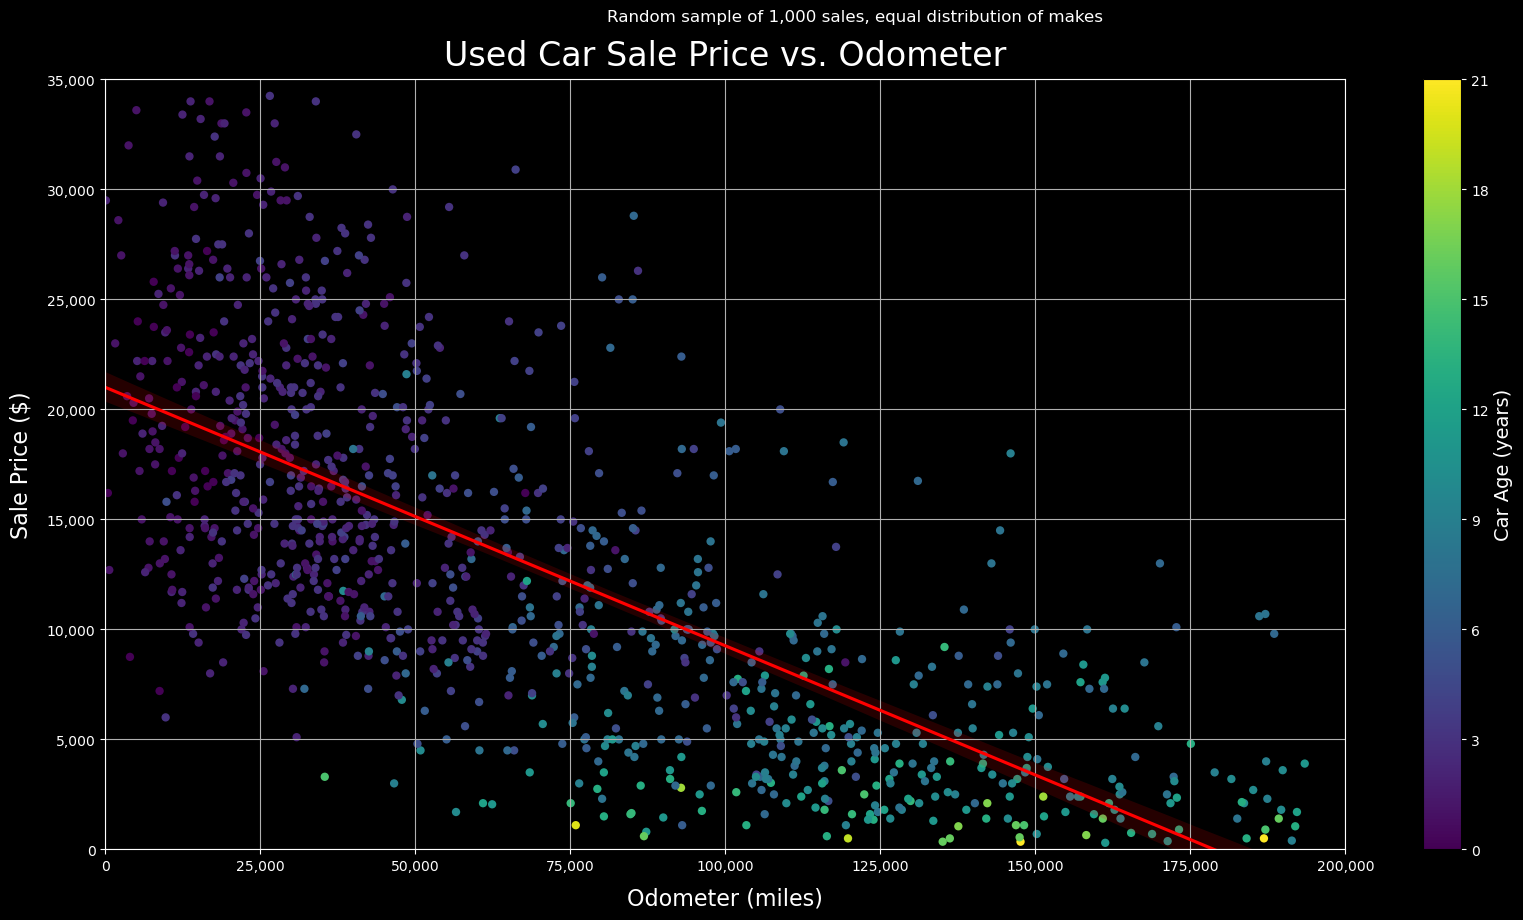

In [51]:
# The full dataset has far too many records for a scatterplot, so we will grab a random sample of 1000
# We will also make sure this random sample is maintaining a uniform proportion of samples from each car make (40 per make, 25 makes = 1000)
sampled = df.groupby('make').sample(40, random_state=1)

# Create a plot
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(0, 35000)
plt.xlim(0, 200000)

# Making the background black
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Making a scatter plot comparing odometer and selling price, but also coloring by age
scatter = ax.scatter(sampled['odometer'], sampled['sellingprice'], c=sampled['age'], cmap='viridis', edgecolor='none')

# Overlaying on that plot a seaborn regplot to show the linear regression line for odometer and price
sns.regplot(data=sampled, x='odometer', y='sellingprice', scatter = False, line_kws={'color': 'red'})

# Set axis labels
ax.set_xlabel('Odometer (miles)', color='white', fontsize=16, labelpad=10)
ax.set_ylabel('Sale Price ($)', color='white', fontsize=16, labelpad=10)
ax.set_title('Used Car Sale Price vs. Odometer', fontsize=24, pad=10)
fig.suptitle('Random sample of 1,000 sales, equal distribution of makes', fontsize=12, color='white', y=0.95)

# Adjust plot elements to be visible against black background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x tick labels to have commas in the thousands place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Car Age (years)', fontsize=14, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
cbar.locator = ticker.MaxNLocator(integer=True)
cbar.update_ticks()

# Add a grid
plt.grid()

# Show the plot
plt.show()

### Findings: Predictably, odometer and car age have a large influence on the selling price.

## How does depreciation vary between types of vehicles?

In [10]:
# Create a dataframe showing the average selling price for each car body type in each odometer bin
body = df.groupby(['body', 'od_bin'])['sellingprice'].mean().reset_index()

# Create a new column to show the percentage change in value from the first odometer bin
body['percentage_diff'] = body.groupby('body')['sellingprice'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)

# Preview the dataframe
body

C:\Users\Alex School\AppData\Local\Temp\ipykernel_40544\4229650419.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  body = df.groupby(['body', 'od_bin'])['sellingprice'].mean().reset_index()


,body,od_bin,sellingprice,percentage_diff
0,CONVERTIBLE,5000,25285.802469,0.000000
1,CONVERTIBLE,10000,23427.533784,-7.349060
2,CONVERTIBLE,15000,24046.351931,-4.901765
3,CONVERTIBLE,20000,24300.000000,-3.898640
4,CONVERTIBLE,25000,24030.600000,-4.964060
...,...,...,...,...
315,WAGON,180000,2027.118644,-87.501011
316,WAGON,185000,2211.702128,-86.362890
317,WAGON,190000,1884.444444,-88.380724
318,WAGON,195000,1844.090909,-88.629540


c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

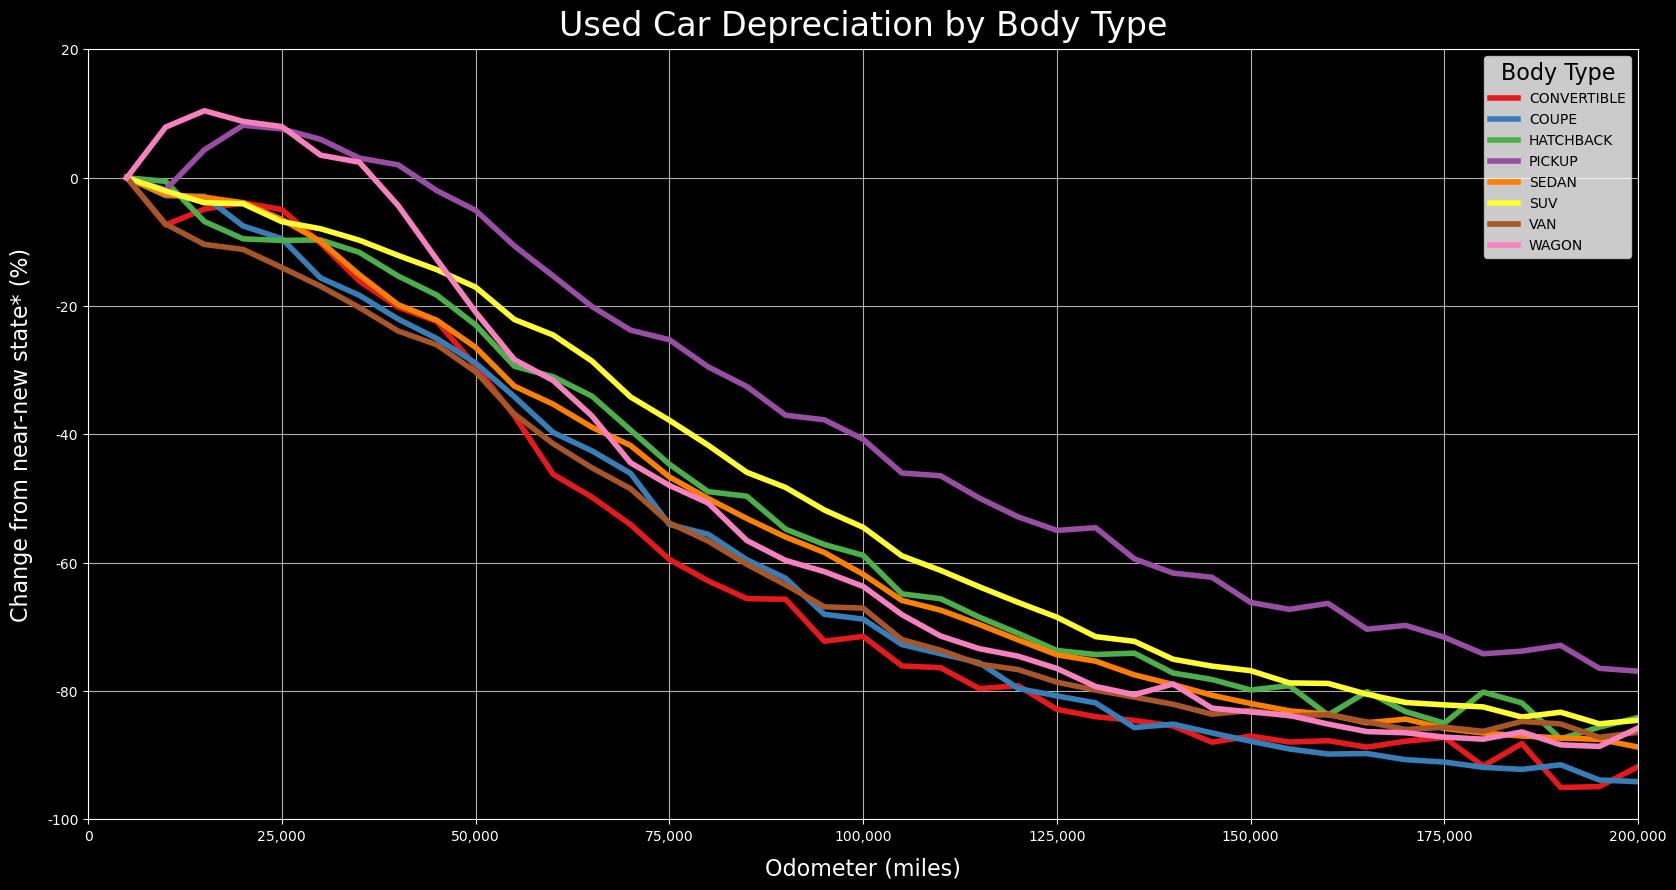

In [56]:
# Generate a rainbow colormap
rainbow_palette = sns.color_palette("Set1", n_colors=len(body['body'].unique()))

# Create a lineplot, with each car body type having a separate line
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=body, x='od_bin', y='percentage_diff', hue='body', palette=rainbow_palette, linewidth=4)
plt.ylim(-100, 20)
plt.xlim(0, 200000)

# Make the background black
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Set axis labels
ax.set_xlabel('Odometer (miles)', color='white', fontsize=16, labelpad=10)
ax.set_ylabel('Change from near-new state* (%)', color='white', fontsize=16, labelpad=10)
ax.set_title('Used Car Depreciation by Body Type', fontsize=24, pad=10)

# Adjust plot elements to be visible against black background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x tick labels to have commas in the thousands place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Increase line width in legend
for line in ax.get_legend().get_lines():
    line.set_linewidth(4)

# Set legend title to 'Type'
legend = ax.get_legend()
legend.set_title('Body Type')
plt.setp(legend.get_title(), color='black', fontsize=16)

# Add a grid
plt.grid()

# Show the plot
plt.show()

### Findings: Trucks seem to hold their value the most overall, and by a significant margin. All other types appear toe depreciate at similar rates to each other, but worth noting that convertibles and coupes depreciate the most, perhaps because they are slightly more niche. Counterintuitively, trucks and wagons appear to *gain* value in the first 25,000 miles before depreciating below their initial price.

## What car makes depreciate the most/least?

In [57]:
# Create a dataframe showing the average selling price for each car make in each odometer bin
odometer = df[df['make'].isin(top25_makes)].groupby(['make', 'od_bin'])['sellingprice'].mean().reset_index()

# Create a new column to show the percentage change in value from the first odometer bin
odometer['percentage_diff'] = odometer.groupby('make')['sellingprice'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)

# Preview the dataframe
odometer

C:\Users\Alex School\AppData\Local\Temp\ipykernel_40544\752193615.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  odometer = df[df['make'].isin(top25_makes)].groupby(['make', 'od_bin'])['sellingprice'].mean().reset_index()


,make,od_bin,sellingprice,percentage_diff
0,ACURA,5000,23989.285714,0.000000
1,ACURA,10000,24227.941176,0.994842
2,ACURA,15000,22593.382353,-5.818862
3,ACURA,20000,22034.523810,-8.148479
4,ACURA,25000,21952.121212,-8.491976
...,...,...,...,...
995,VOLKSWAGEN,180000,1466.071429,-91.430698
996,VOLKSWAGEN,185000,1670.312500,-90.236893
997,VOLKSWAGEN,190000,1463.888889,-91.443455
998,VOLKSWAGEN,195000,1571.551724,-90.814157


In [23]:
# Using regression to find how many miles it typically takes for cars to lose 25%, 50%, and 75% of their value

# Creating an empty dictionary to store data
result = {}

# Iterating through each car make
for car_make in odometer['make'].unique():
    # Create an entry for the make in the dictionary, value will be an empty list to populate
    result[car_make] = []
    for i in [-25, -50, -75]:
        # Isolating that car make in the data
        car_data = odometer[odometer['make'] == car_make]

        # Create an interpolation function for that car's depreciation through the odometer bins
        f = interp1d(car_data['percentage_diff'], car_data['od_bin'], fill_value="extrapolate")

        # Calculate the odometer for the given depreciation milestone (25%, 50%, 75%)
        odometer_mark = f(i)

        # Append it to the list for that car
        result[car_make] = result[car_make] + [odometer_mark.item()]

# Create a dataframe from the results, and drop null values because Pontiac did not have enough data
depdf = pd.DataFrame(result).transpose().dropna()

# Set column names and sort by the 50% depreciation point
depdf.columns=['25%', '50%', '75%']
depdf = depdf.sort_values('50%')

# Preview the dataframe
depdf

C:\Users\Alex School\AppData\Local\Temp\ipykernel_40544\814633160.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu')


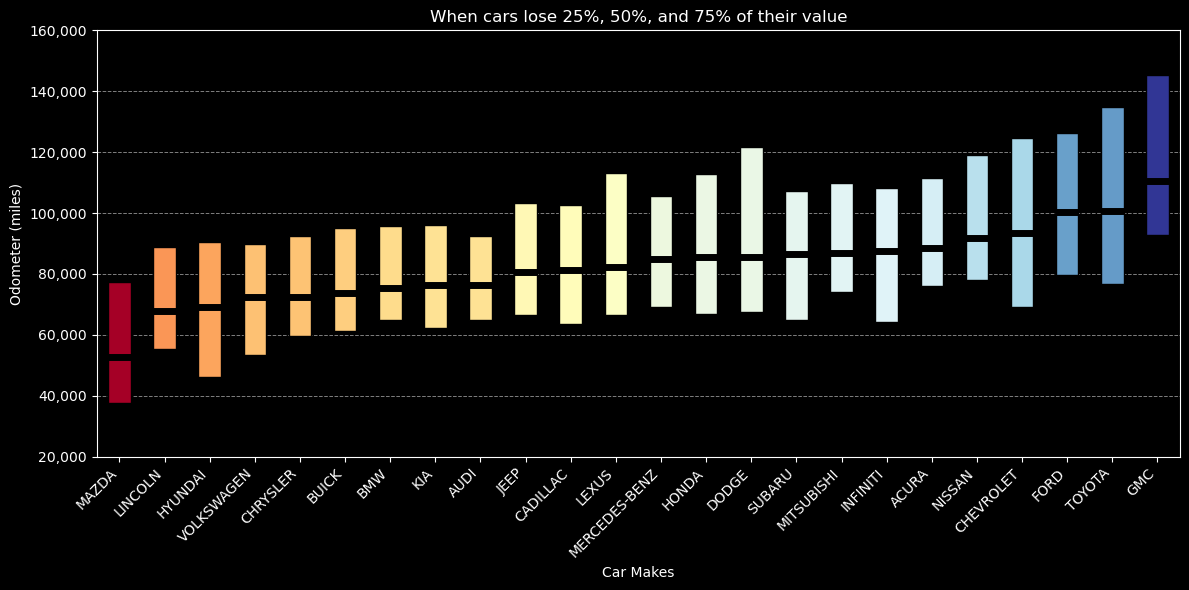

In [50]:
# Drop the index because ax.boxplot keeps giving me problems if I don't
depdata = depdf.reset_index()

# Prepare data for boxplot
boxplot_data = []

# Iterate over each row to prepare the data
for index, row in depdata.iterrows():
    boxplot_data.append([row['25%'], row['50%'], row['75%']])

# Convert to DataFrame for better handling
boxplot_df = pd.DataFrame(boxplot_data, columns=['25%', '50%', '75%'])

## I'd like to color each box based on its 50% values, with a gradient scale
# Normalize the '50%' column values to a range between 0 and 1
norm = plt.Normalize(boxplot_df['50%'].min(), boxplot_df['50%'].max())

# Create a colormap
cmap = cm.get_cmap('RdYlBu')

# Create the plots
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the boxplot without whiskers and caps, and enable patch_artist to fill the boxes
box = ax.boxplot(boxplot_data, labels=depdf.index, 
                 showmeans=False, whiskerprops={'visible': False}, capprops={'visible': False},
                 patch_artist=True)

# Set labels, ticks, and dimensions
plt.xlabel('Car Makes', color='white')
plt.ylabel('Odometer (miles)', color='white')
plt.title('When cars lose 25%, 50%, and 75% of their value', color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.ylim((20000, 160000))

# Set background to black
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Customize the spines to be white
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Color the boxes based on the '50%' column values
for i, patch in enumerate(box['boxes']):
    # Normalize the '50%' value to a range between 0 and 1
    color_value = norm(boxplot_df['50%'][i])
    # Get the corresponding color from the colormap
    color = cmap(color_value)
    # Set the facecolor of the box
    patch.set_facecolor(color)


# Customize the medians
for element in ['medians']:
    plt.setp(box[element], color='white')

# Customize the medians to be thicker and blue
for median in box['medians']:
    median.set(color='black', linewidth=5)

# Customize the tick labels colors
ax.tick_params(colors='white')
ax.yaxis.grid(True, color='white', linestyle='--', linewidth=0.7, alpha=0.5)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))


# Display the plot
plt.tight_layout()
plt.show()


### Findings: By a large margin, Mazda vehicles depreciate the fastest, losing half their value after a little over 50,000 miles. GMC had the least depreciation, though that probably has a lot to do with the fact that most of GMC's vehicles are trucks, which are a low depreciation vehicle type. Anecdotally, the makes with the least depreciation are often touted by others as being reliable cars.